In [1]:
%matplotlib widget

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import threading
import time

import numpy as np
import time
from rr_python_sdk import cpp, MeasurementHead, msg_map_to_host

In [2]:
head = MeasurementHead()

USB Serial Port (COM6) 1027
Auto detected: USB Serial Port (COM6)
Handshake acknowledged: <rr_python_sdk.mh_protocol_py.HandshakeToHostPayload object at 0x000002A702D9C630>


In [114]:
head.shakehands()

Handshake acknowledged: <rr_python_sdk.mh_protocol_py.HandshakeToHostPayload object at 0x000002A7034A8570>


True

In [115]:
head.zero_forces()

In [121]:
head.write_config_to_flash()

In [119]:
payload = cpp.SetForcePayload()
payload.force_mn = 30000
head.start_force_control(payload)

In [69]:
payload = cpp.SetForcePayload()
payload.force_mn = 50000
head.update_set_force(payload)

In [117]:
payload = cpp.PidConfig()
payload.diferential_decay = 0.5
payload.n_settle = 10
payload.PID_P = 0.0008
payload.PID_D = 50
head.update_pid_config(payload)

In [120]:
head.home()

In [4]:
payload = cpp.JogPayload()
payload.distance_mm = 5.0
head.jog_motor(payload)

In [55]:
head.request_current_force_data()

In [36]:
head.enter_load_cell_calibration_mode_normal()

In [28]:
coeff_n = cpp.LoadCellCalibrationCoef()
coeff_n.OFFSET_B = 0b1100000000110111 # was 0b1111101000111111
coeff_n.GAIN_B = 0b1001001110110101

In [29]:
head.write_calibration_coefficients_normal(coeff_n)

In [37]:
head.exit_load_cell_calibration_mode_normal()

In [10]:
head.enter_load_cell_calibration_mode_tangential()

In [12]:
coeff_t = cpp.LoadCellCalibrationCoef()
coeff_t.OFFSET_B = 0b0
coeff_t.GAIN_B = 0b100100111011010 # just half the gain, no offset

In [14]:
head.write_calibration_coefficients_tangential(coeff_t)

In [7]:
head.request_angle()

In [32]:
head.request_acceleration_data()

In [33]:
head.request_orientation()

In [31]:
a = head.read()
match a.type:
    case cpp.MsgType_ToHost.ERR:
        print(f"Error {a.data.reason}")
    case cpp.MsgType_ToHost.FaultData:
        print(f"Fault {a.data.fault_status:0b}, {int(np.log2(a.data.fault_status))}")
    case cpp.MsgType_ToHost.ACK:
        print(f"Ack {a.data.msg_type}")
    case cpp.MsgType_ToHost.NoMessage:
        print("No message")
    case cpp.MsgType_ToHost.CurrentData:
        print(f"Force data: N {a.data.f_normal_mn}mN, T {a.data.f_tangential_mn}mN")
    case cpp.MsgType_ToHost.OrientationData:
        print(f"Orientation data: incline: {a.data.incline}, roll: {a.data.roll}")
    case _:
        print("Message:", a.type, a.data)

No message


In [122]:
a = head.read_all()
a

[Message(type=<MsgType_ToHost.ACK: 6>, data=<rr_python_sdk.mh_protocol_py.AckPayload object at 0x000002A70300EF30>),
 Message(type=<MsgType_ToHost.ACK: 6>, data=<rr_python_sdk.mh_protocol_py.AckPayload object at 0x000002A7030878F0>),
 Message(type=<MsgType_ToHost.ACK: 6>, data=<rr_python_sdk.mh_protocol_py.AckPayload object at 0x000002A7034516B0>),
 Message(type=<MsgType_ToHost.ACK: 6>, data=<rr_python_sdk.mh_protocol_py.AckPayload object at 0x000002A7030260F0>),
 Message(type=<MsgType_ToHost.ACK: 6>, data=<rr_python_sdk.mh_protocol_py.AckPayload object at 0x000002A703026070>),
 Message(type=<MsgType_ToHost.ACK: 6>, data=<rr_python_sdk.mh_protocol_py.AckPayload object at 0x000002A703010AF0>)]

In [17]:
a[-2].data.reason

<error_reason_t.E_UNRECOGNISED_COMMAND: 7>

In [32]:
f"{np.log2(a[1].data.fault_status)}"

'17.0'

In [51]:
head.clear_fault()

In [ ]:
print(f"Force data: N {a.data.f_normal_mn}mN, T {a.data.f_tangential_mn}mN")

In [46]:
head.reset_to_defaults()

In [ ]:
head.exit_load_cell_calibration_mode_normal()

In [16]:
head.restart()

In [11]:
f"{0X27:0b}"

'100111'

In [ ]:
f"{0b100100111011010:0X}"

C:\Users\mea08\AppData\Local\Temp\ipykernel_13564\4011031760.py:72: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = animation.FuncAnimation(fig, update_wrap, blit=True, interval=100)


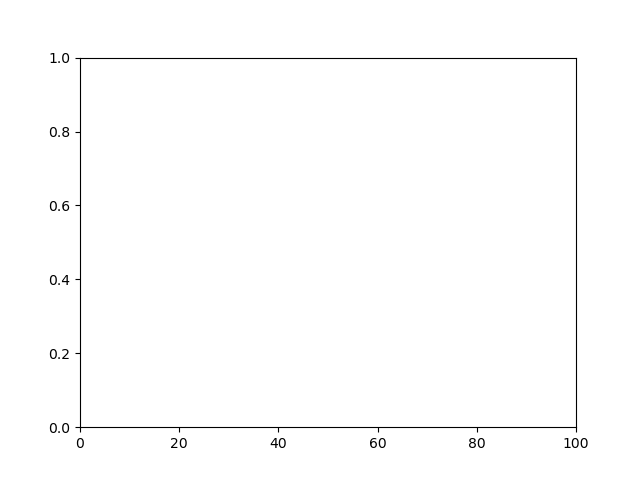

In [43]:
import random

# Global variables
data_n = []
data_t = []
running = True
ani = None  # We'll store the animation object here

# Clean-up function
def cleanup():
    head.stop_data_streaming()
    # Close files, serial ports, etc.

# Function to stop on spacebar
def on_key(event):
    global running, ani
    if event.key == ' ':
        cleanup()
        running = False
        if ani:
            ani.event_source.stop()

# Setup plot
fig, ax = plt.subplots()
line_n, = ax.plot([], [], 'b-')
line_t, = ax.plot([], [], 'r-')
ax.set_xlim(0, 100)
ax.set_ylim(0, 1)
fig.canvas.mpl_connect('key_press_event', on_key)

# Dummy read function (replace with your actual read)
def read(cpp, head):
    new_d_t = []
    new_d_n = []
    
    msgs = head.read_all(timeout = 0.1)
    for msg in msgs:
        match msg.type:
            case cpp.MsgType_ToHost.FaultData:
                print(f"Fault {msg.data.fault_status:0b}, {int(np.log2(msg.data.fault_status))}")
                on_key(None)
                return
            case cpp.MsgType_ToHost.CurrentData:
                new_d_n.append(float(msg.data.f_normal_mn))
                new_d_t.append(float(msg.data.f_tangential_mn))
    return new_d_n, new_d_t

# Animation update function
def update(frame):
    global data_n, data_t, cpp, head
    print(f"running")
    if running:
        val_n, val_t = read(cpp, head)
        data_n.extend(val_n)
        data_t.extend(val_t)
        if len(data) > 100:  # keep last 100 points
            data_n = data_n[-100:]
            data_t = data_t[-100:]
        line_n.set_data(range(len(data_n)), data_n)
        line_t.set_data(range(len(data_t)), data_t)
    return line_n, line_t

def update_wrap(frame):
    try:
        # Your code goes here
        update(frame)
    except Exception as e:
        print(f"Exception occurred: {e}")
        raise

# Animation
ani = animation.FuncAnimation(fig, update_wrap, blit=True, interval=100)

payload = cpp.DataRatePayload()
payload.rate_hz = sampling_rate
head.start_data_streaming(payload)

# Show plot (blocking)
plt.show()

In [186]:
status = 400
match status:
    case 400:
        print("Bad request")
    case 404:
        print ("Not found")

Bad request


In [12]:
head.request_acceleration_data()

In [24]:
head.__repr__()

'<rr_python_sdk.wrapper.MeasurementHead object at 0x00000245CAF58F50>'

In [ ]:
a = head.read()
print(a.data.x, a.data.y, a.data.z)

In [ ]:
head.restart()

In [ ]:
a.data.fault_status

In [ ]:
a = cpp.FaultStatusPayload()

In [ ]:
f"{0x1f:b}"

In [ ]:
0x6081

In [ ]:
a = cpp.HandshakeToDevicePayload()

In [ ]:
import rr_python_sdk as a

In [ ]:
a.msg_map_to_host

In [ ]:
head.read()

In [ ]:
payload = cpp.JogPayload()
payload.distance_mm = 1
head.jog_motor(payload)

In [ ]:
payload = cpp.AccelerationData()
payload.x = 1

In [ ]:
payload = cpp.HandshakeToDevicePayload()


In [ ]:
locals()['hs']

In [ ]:
my_head = head.MeasurementHead("COM5")

In [ ]:
my_head.ack()

In [ ]:
head.read()

In [ ]:
head.cpp.AccelerationData()

In [ ]:
head.cpp.MsgType_ToHost.

In [ ]:
# --- Force Data Point ---
force = cpp.ForceDataPoint()  # corresponds to force_data_point_t
force.device_status = 2
force.f_normal_mn = 123456
force.f_tangential_mn = -654321
force.millis_since_start = 500

# Serialize to bytes
# We'll use memoryview/bytearray approach
force_bytes = force.serialize()

# Prepend tag for ESP (0x00)
frame = bytes([0x00]) + force_bytes
ser.write(frame)
print("Sent force_data_point_t: 0x" + ' 0x'.join(f'{x:02X}' for x in frame)[0:])

In [ ]:
# AccelerationData
accel = cpp.AccelerationData()
accel.x = 1.1
accel.y = 2.2
accel.z = 3.3
accel.t = 4.4

accel_bytes = accel.serialize()
ser.write(bytes([0x01]) + accel_bytes)
print("Sent acceleration_data_t:", accel_bytes)

In [ ]:
payload = b"Hello ESP32!\r\n"

print(f"Sending {len(payload)} bytes: {payload}")
ser.write(payload)

# Read back the same number of bytes
rx = ser.read(len(payload))
print(f"Received {len(rx)} bytes: {rx}")

# Compare
if rx == payload:
    print("✅ Echo OK")
else:
    print("❌ Mismatch!")
    print("Sent :", binascii.hexlify(payload))
    print("Recv :", binascii.hexlify(rx))

In [ ]:
ser.close()

In [ ]:
head = sdk.MeasurmentHead(port = "COM11")
head.read_all_input()

# Test all functions
 (In order they are in the microcontroller code)

## Angle setting

In [ ]:
head.set_angle(10)

## Echo input

In [ ]:
head.echo(b"Hello")

## Read and write config data
Note, the default config will be reloaded when the device restarts

In [ ]:
config = head.read_config_data()
config.microsteps_per_step

In [ ]:
config.t_force_scale

In [ ]:
config.microsteps_per_step = 8

In [ ]:
head.update_config_data(config)

In [ ]:
config = head.read_config_data()

In [ ]:
config.microsteps_per_step

## Data streaming

In [ ]:
i = 0
points = []
head.read_all_input()
head.start_streaming_force_data(100)
while (i<200):
    points.append(head.read_force_data_point_from_stream())
    i+=1
head.stop_streaming_force_data()
#plt.plot([p.ms_since_start for p in points], [p.f_t_mn/p.f_n_mn for p in points], label="mu")
plt.plot([p.ms_since_start for p in points], [p.f_n_mn for p in points], label="Normal force (mn)")
plt.plot([p.ms_since_start for p in points], [p.f_t_mn for p in points], label="Tangential force (mn)")
plt.legend()

In [ ]:
head.stop_streaming_force_data()
head.read_all_input()

## Show and reset error data

In [ ]:
f"{head.read_error_status():016b}"

In [ ]:
head.clear_error_status()

## Setting target force

In [ ]:
head.set_target_force(100000)

## Home

In [ ]:
head.home()

## Jog

In [ ]:
head.jog(100)

## Toggle LEDS

In [ ]:
head.toggle_led(True)
time.sleep(0.5)
head.toggle_led(False)
time.sleep(0.5)
head.toggle_led(True)
time.sleep(0.5)
head.toggle_led(False)

## Change state to None

In [ ]:
head.stop_all()

## Send current data

In [ ]:
head.read_single_force_data_point()

## Restart

In [ ]:
head.restart()

In [ ]:
head.read_all_input()

## Start test

In [ ]:
head.maintain_force(100000)

In [ ]:
i = 0
points = []
head.read_all_input()
head.start_streaming_force_data(100)
while (i<200):
    points.append(head.read_force_data_point_from_stream())
    i+=1
head.stop_streaming_force_data()

centre=0
vals = np.sort([p.f_t_mn for p in points])
span = np.mean(vals[-50:])-np.mean(vals[:50])
plt.plot([p.ms_since_start for p in points], [p.f_n_mn for p in points], label="Normal force (mn)")
plt.plot([p.ms_since_start for p in points], [p.f_t_mn for p in points], label="Tangential force (mn)")
plt.plot([0,2000], [centre, centre], 'k:')
plt.plot([0,2000], [centre-span/2, centre-span/2], 'g-')
plt.plot([0,2000], [centre+span/2, centre+span/2], 'g-')
plt.legend()

In [ ]:
head.stop_all()

## Zero all forces

In [ ]:
head.home()

In [ ]:
head.zero_forces()

## Incline and roll

In [ ]:
head.read_all_input()
head.read_orientation_data()